In [1]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import uuid
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Collection

In [ ]:
IMAGES_PATH = 'data'
number_images = 11

In [ ]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,'images',f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
!labelme

### Creating Dataset

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
# train 54, test 12, val 14

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

### Using Albumentations for generating new augmented images

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                        keypoint_params=alb.KeypointParams(format='xy', label_fields=['class_labels']))

In [ ]:
imgg = cv2.imread(os.path.join('data', 'train', 'images', 'dddc3e60-1108-11ee-a0b7-aca5db1ce10e.jpg'))
plt.imshow(imgg)

In [ ]:
print(imgg.shape)

In [ ]:
for partition in ['train', 'test', 'val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        classes = [0,0]
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
    
            if label['shapes'][0]['label']=='leftEye': 
                classes[0] = 1
                coords[0] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[1] = np.squeeze(label['shapes'][0]['points'])[1]

            if label['shapes'][0]['label']=='rightEye':
                classes[1] = 1
                coords[2] = np.squeeze(label['shapes'][0]['points'])[0]
                coords[3] = np.squeeze(label['shapes'][0]['points'])[1]

            if len(label['shapes']) > 1:     
                if label['shapes'][1]['label'] =='leftEye': 
                    classes[0] = 1 
                    coords[0] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[1] = np.squeeze(label['shapes'][1]['points'])[1]

                if label['shapes'][1]['label'] =='rightEye': 
                    classes[1] = 1
                    coords[2] = np.squeeze(label['shapes'][1]['points'])[0]
                    coords[3] = np.squeeze(label['shapes'][1]['points'])[1]
            
            np.divide(coords, [640,480,640,480])
                
        try: 
            for x in range(120):
                keypoints = [(coords[:2]), (coords[2:])]
                augmented = augmentor(image=img, keypoints=keypoints, class_labels=['leftEye','rightEye'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                annotation['class'] = [0,0]
                annotation['keypoints'] = [0,0,0,0]

                if os.path.exists(label_path):
                    if len(augmented['keypoints']) > 0: 
                        for idx, cl in enumerate(augmented['class_labels']):
                            if cl == 'leftEye': 
                                annotation['class'][0] = 1 
                                annotation['keypoints'][0] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][1] = augmented['keypoints'][idx][1]
                            if cl == 'rightEye': 
                                annotation['class'][1] = 1 
                                annotation['keypoints'][2] = augmented['keypoints'][idx][0]
                                annotation['keypoints'][3] = augmented['keypoints'][idx][1]
                                
                annotation['keypoints'] = list(np.divide(annotation['keypoints'], [450,450,450,450]))


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### Loading the data

In [4]:
# MCSBP
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### Loading labels

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['keypoints']]

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### Combining Images and Labels

In [11]:
## MCSBP
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [12]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [13]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### Sample Images

In [14]:
data_samples = train.as_numpy_iterator()

In [15]:
res = data_samples.next()

In [16]:
res[1]

(array([[0.     , 0.     , 0.     , 0.     ],
        [0.6055 , 0.2122 , 0.7437 , 0.2202 ],
        [0.758  , 0.425  , 0.6494 , 0.3477 ],
        [0.596  , 0.2208 , 0.     , 0.     ],
        [0.511  , 0.413  , 0.7104 , 0.42   ],
        [0.959  , 0.4692 , 0.86   , 0.3813 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.6016 , 0.2495 , 0.     , 0.     ],
        [0.538  , 0.2363 , 0.     , 0.     ],
        [0.915  , 0.1506 , 0.     , 0.     ],
        [0.4639 , 0.796  , 0.615  , 0.825  ],
        [0.     , 0.     , 0.2798 , 0.2286 ],
        [0.4165 , 0.7876 , 0.2786 , 0.78   ],
        [0.9453 , 0.08826, 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.2532 , 0.7437 ]], dtype=float16),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


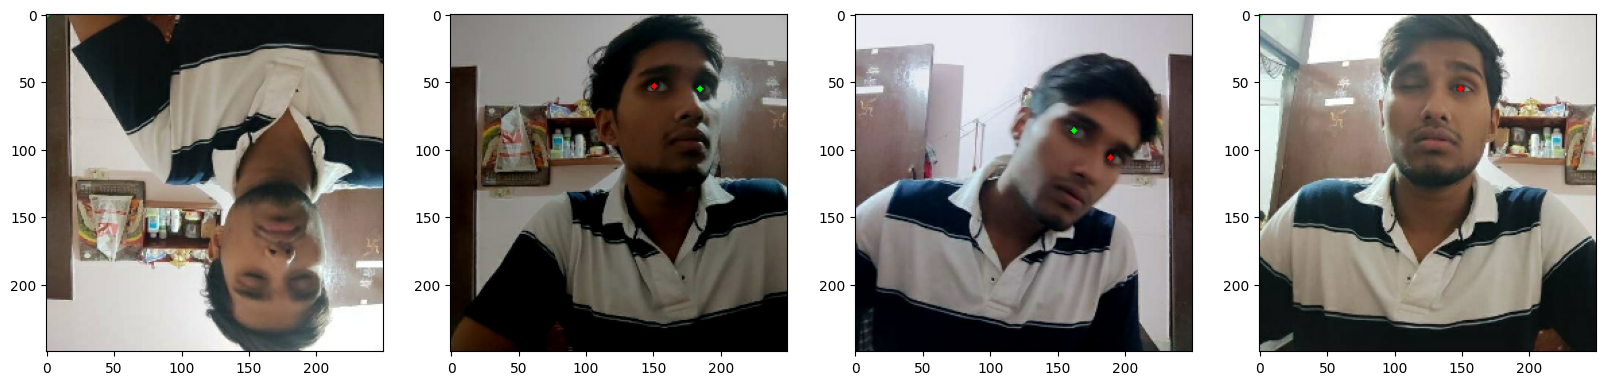

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### Building Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2, ResNet50V2

In [37]:
model = Sequential()
model.add(Input(shape=(250,250,3)))
model.add(ResNet50V2(include_top=False, input_shape=(250,250,3)))
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, 2, padding='same', activation='relu'))
model.add(Conv2D(256, 2, 2, activation='relu'))
model.add(Dropout(0.05))
model.add(Conv2D(4,2,2))
model.add(Reshape((4,)))

94668760/94668760 [==============================] - 23s 0us/step


In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 4)          

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [40]:
model.compile(optimizer, loss)

### Training the model

In [30]:
x, y = train.as_numpy_iterator().next()

In [33]:
x.shape

(16, 250, 250, 3)

In [41]:
hist = model.fit(train, epochs=1, validation_data=val)

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_2/resnet50v2/conv3_block2_2_conv/Conv2D' defined at (most recent call last):
    File "C:\Users\shri0\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\shri0\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\shri0\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\shri0\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\shri0\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\shri0\AppData\Local\Temp\ipykernel_2592\236186773.py", line 1, in <module>
      hist = model.fit(train, epochs=1, validation_data=val)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "D:\N Renotte DL Projects\face_detection\facedtc\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_2/resnet50v2/conv3_block2_2_conv/Conv2D'
OOM when allocating tensor with shape[16,128,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_2/resnet50v2/conv3_block2_2_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_98787]